<a href="https://colab.research.google.com/github/igormatheusdiniz/ri_lab_04/blob/master/ri_lab4_igor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [440]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import heapq as hp

# Memory use
!pip install memory_profiler
%load_ext memory_profiler

import nltk
nltk.download('rslp')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import heapq as hp


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
url = 'https://raw.githubusercontent.com/Benardi/ri_lab_01/master/output/results.csv'

Utilizei a base de dados de Benardi, e por motivos de não precisar importar o .csv toda vez ao inicializar o colab, defini a url em meu lab.

# Tratamento dos dados

In [0]:
dataframe = pd.read_csv(url)
dataframe['treatedText'] = dataframe.text.apply(lambda x: re.sub('[^0-9A-ZÀ-Úa-zà-ú\']', ' ', x.lower()))

Diferente do lab anterior onde para obter os tokens, não utilizei o método tokenize do ntlk, para atender as especificações do lab atual, atualizei a forma que recupero os tokens do meu texto.

In [0]:
regex = RegexpTokenizer(r'[A-zÀ-ú-]+')
stopWords = set(stopwords.words('portuguese'))

# Questão 1

## Algoritimo de construção de índice Invertido

In [0]:
def ocurrences(list, token):
  print(list)
  print(token)
  count = 0
  for word in list:
    if word==token:
      count +=1
  return count
      

def invertedIndex(documents):
  I = {}
  index = 0
  
  ##Para cada documento na minha relação de documentos irei realizar o processo de tokenização
  for document in documents.treatedText:
    index += 1
    T = [token for token in regex.tokenize(document)
        if((len(token)>=3) and token not in stopWords and token[0] != "[" and token[-1]!="]")]
    
    ##Por motivos didáticos, resolvi ordenar minha lista de tokens
    T.sort()
    
    ## Pra cada token criado se ele ainda não existe na minha estrutura de armazenamento como uma chave, eu crio e em seguida adiciono
    ##o indice do documento como valor para esta chave
    ## Caso já exista, apenas adiciona o índice do documento para esta chave
    for token in T:
      if token not in I.keys():
        I[token]=[]
       
      pair = []
      ocurrence = T.count(token)
     
      pair.append(index)
      pair.append(ocurrence)
      if(pair not in I[token]):
        I[token].append(pair)
  ## Por motivos estéticos resolvi comentar esta linha para não ficar uma lista de print muito grande no gitHub, dificultando a visualização do documento como um todo      
  ##print(I)
  return I

## Exportando para .csv
invertedIndex = invertedIndex(dataframe)
data = {'token': list(invertedIndex.keys()), 'ocurrences': list(invertedIndex.values())}
df = pd.DataFrame(data)
df.to_csv('index.csv')

# Questão 2

## Algoritimo Documento por vez  

In [445]:
def documentAtTimeRetrieval(terms, invertedIndex, k, documents):
  invertedLists = []
  R = []
  
  ##Para cada termo recebido, se este termo está contindo nas chaves do meu IndiceInvertido construído anteriormente
  ##adicione na minha estrutura de listas invertidas 
  for term in terms.split():
    if term in invertedIndex.keys():
      invertedLists.append(invertedIndex[term])
  
  ##Para cada documento recuperado vamos calcular o score
  for document in range(documents.treatedText.count()):
    score = 0
    for invertedList in invertedLists:
      for value in invertedList:
        if document == value[0]:
          score += value[1]
    if score != 0:
      R.append((score,document)) 
  
  ##Ordenando nossa estrutura de resposta, e selecionando os k-ésimos elementos
  R.sort(reverse=True) 
  result = R[0:k]
  
  
  return result
    
    
resultado = documentAtTimeRetrieval('juíza federal', invertedIndex, 5, dataframe)

print(resultado)

[(5, 151), (4, 173), (4, 1), (3, 248), (3, 229)]


## Algoritimo Termo por vez

In [446]:
def termAtTimeRetrieval(terms, invertedIndex, k):
  hashtable = {}
  invertedLists =[]
  R = []
  
  ##Para cada termo recebido, se este termo está contindo nas chaves do meu IndiceInvertido construído anteriormente
  ##adicione na minha estrutura de listas invertidas 
  for term in terms.split():
    if term in invertedIndex.keys():
      invertedLists.append(invertedIndex[term])
  
  
  ## DIferente do algoritimo documentoPorVez iremos ACUMULAR os scores para cada termo
  ## Para isso analisamos, os valores de cada chave/termo em nossa estrutura
  ## nosso value 0 será o "índice" do documento, enquanto que o value 1 a frequência
  ## Se nosso documento ja existir na hashtable de retorno iremos apenas atualizar o score acumulando-o
  ## Caso contrário iremos cria-ló em nossa hashtable e atribuir um score = frequencia para ele.
  
  for invertedList in invertedLists:
    for value in invertedList:
      d = value[0]
      f = value[1]
      if d in hashtable.keys():
        hashtable[d] = hashtable[d] + f
      else:  
        hashtable[d] = f
  
  R = list(map(lambda elem: (elem[1],elem[0]), hashtable.items()))
  
  ##Ordenando nossa estrutura de resposta, e selecionando os k-ésimos elementos
  R.sort(reverse=True) 
  result = R[0:k]
  
  return result

resultado = documentAtTimeRetrieval('juíza federal', invertedIndex, 5, dataframe)

print(resultado)

[(5, 151), (4, 173), (4, 1), (3, 248), (3, 229)]


In [0]:
## Definindo 5 consultas de um termo, para testarmos ambos algoritimos
consultas = ['escola','bolsonaro', 'lula', 'universidades', 'infantil']

##  Consultas Documento por vez

In [448]:
## Estrutura para armazenamento dos resultados das pesquisas, para futura conversão em coluna de tabela
documentAtTimeResult = []

## Estrutura para armazenamento dos tempos de execução, para futura conversão em coluna de tabela
tempoResultados = []

## Variáveis auxiliares para calcular o tempo de execução
tempoInicial = 0
tempoFinal = 0

for pesquisa in consultas:
  tempoInicial = time.time()
  consulta = documentAtTimeRetrieval(pesquisa, invertedIndex, 10, dataframe)
  tempoFinal = time.time()
  tempo = tempoFinal - tempoInicial
  tempoResultados.append(tempo)
  documentAtTimeResult.append(consulta)


table = pd.DataFrame()
pd.options.display.max_colwidth = 160

table['termo'] = consultas
table['DocumentoPorVez'] = documentAtTimeResult
table['tempoExec_DocVez'] = tempoResultados

table

,termo,DocumentoPorVez,tempoExec_DocVez
0,escola,"[(9, 239), (5, 214), (4, 80), (2, 217), (2, 166), (2, 160), (2, 130), (2, 110), (2, 95), (2, 94)]",0.000958
1,bolsonaro,"[(46, 151), (37, 166), (35, 207), (26, 19), (12, 216), (12, 208), (12, 42), (8, 235), (8, 225), (8, 111)]",0.001430
2,lula,"[(9, 15), (3, 234), (3, 216), (2, 226), (2, 204), (2, 168), (1, 238), (1, 236), (1, 172), (1, 138)]",0.000403
3,universidades,"[(6, 130), (3, 110), (2, 216), (2, 115), (1, 214), (1, 155), (1, 129), (1, 92), (1, 69), (1, 34)]",0.000377
4,infantil,"[(4, 203), (2, 198), (2, 31), (1, 242), (1, 186), (1, 184), (1, 180), (1, 147), (1, 52)]",0.000351


## Consultas Termo por vez

In [449]:
## Estrutura para armazenamento dos resultados das pesquisas, para futura conversão em coluna de tabela
termAtTimeResult = []

## Estrutura para armazenamento dos tempos de execução, para futura conversão em coluna de tabela
tempoResultados = []

## Variáveis auxiliares para calcular o tempo de execução
tempoInicial = 0
tempoFinal = 0

for pesquisa in consultas:
  tempoInicial = time.time()
  consulta = termAtTimeRetrieval(pesquisa, invertedIndex, 10)
  tempoFinal = time.time()
  tempo = tempoFinal - tempoInicial
  tempoResultados.append(tempo)
  termAtTimeResult.append(consulta)


table['TermoPorVez'] = termAtTimeResult
table['tempoExec_TermVez'] = tempoResultados

table

,termo,DocumentoPorVez,tempoExec_DocVez,TermoPorVez,tempoExec_TermVez
0,escola,"[(9, 239), (5, 214), (4, 80), (2, 217), (2, 166), (2, 160), (2, 130), (2, 110), (2, 95), (2, 94)]",0.000958,"[(9, 239), (5, 214), (4, 80), (2, 217), (2, 166), (2, 160), (2, 130), (2, 110), (2, 95), (2, 94)]",0.000059
1,bolsonaro,"[(46, 151), (37, 166), (35, 207), (26, 19), (12, 216), (12, 208), (12, 42), (8, 235), (8, 225), (8, 111)]",0.001430,"[(46, 151), (37, 166), (35, 207), (26, 19), (12, 216), (12, 208), (12, 42), (8, 235), (8, 225), (8, 111)]",0.000097
2,lula,"[(9, 15), (3, 234), (3, 216), (2, 226), (2, 204), (2, 168), (1, 238), (1, 236), (1, 172), (1, 138)]",0.000403,"[(9, 15), (3, 234), (3, 216), (2, 226), (2, 204), (2, 168), (1, 238), (1, 236), (1, 172), (1, 138)]",0.000040
3,universidades,"[(6, 130), (3, 110), (2, 216), (2, 115), (1, 214), (1, 155), (1, 129), (1, 92), (1, 69), (1, 34)]",0.000377,"[(6, 130), (3, 110), (2, 216), (2, 115), (1, 214), (1, 155), (1, 129), (1, 92), (1, 69), (1, 34)]",0.000024
4,infantil,"[(4, 203), (2, 198), (2, 31), (1, 242), (1, 186), (1, 184), (1, 180), (1, 147), (1, 52)]",0.000351,"[(4, 203), (2, 198), (2, 31), (1, 242), (1, 186), (1, 184), (1, 180), (1, 147), (1, 52)]",0.000014


## Evidenciando a corretude das implementações

Ao compararmos as consultas das colunas DocumentoPorVez e TermoPorVez podemos perceber que temos o mesmo resultado, indicando que de fato ambos algoritimos estão concordando entre si.

## Sobre os tempos de execução dos algoritimos e uso de memória

É possível perceber que o algoritimo termoPorVez nos retorna uma resposta em um tempo consideravelmente menor quando levamos em consideração o algoritimo documentoPorVez, isso acontece porque a abordagem documentoPorVez calcula scores completos para documentos, processando todas as listas de termos, um documento por vez, enquanto que a abordagem termoPorVez acumula scores processando listas de termos o que requer um tempo consideravelmente menor. Na própria tabela podemos perceber a diferença relatada. Para fins didáticos resolvi plotar em um gráfico as diferenças de tempo de execução, onde a linha em azul reflete o tempo de execução do algoritimo documentoPorVez e linha amarela reflete o tempo de execução do algoritimo termoPorVez.


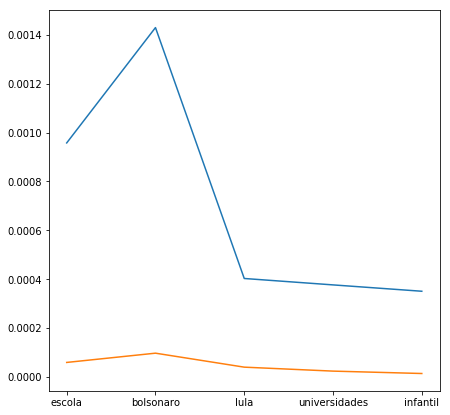

In [450]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="linear", yscale="linear")
plt.plot(table["termo"], 
         table["tempoExec_DocVez"],
         linestyle='-',
         marker='')


plt.plot(table["termo"],
         table["tempoExec_TermVez"],
         linestyle='-',
         marker='')

Quanto ao uso de memória, tentei utilizar algumas opções mas em todas elas o consumo de memória resultou em números iguais, não sei o motivo para tal acontecimento, entretanto fica aqui registrado como tentei calcular o uso de memória.

In [451]:
for consulta in consultas:
  print("Para o termo: " + consulta) 
  print("Memoria - DOCUMENT POR VEZ")
  %memit documentAtTimeRetrieval(consulta, invertedIndex, 10, dataframe)
  print("  ")
  print("Memoria - TERMO POR VEZ")
  %memit termAtTimeRetrieval(consulta, invertedIndex, 10)
  print("%%%%%%%%%")

Para o termo: escola
Memoria - DOCUMENT POR VEZ
peak memory: 278.44 MiB, increment: 0.00 MiB
  
Memoria - TERMO POR VEZ
peak memory: 278.44 MiB, increment: 0.00 MiB
%%%%%%%%%
Para o termo: bolsonaro
Memoria - DOCUMENT POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
  
Memoria - TERMO POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
%%%%%%%%%
Para o termo: lula
Memoria - DOCUMENT POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
  
Memoria - TERMO POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
%%%%%%%%%
Para o termo: universidades
Memoria - DOCUMENT POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
  
Memoria - TERMO POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
%%%%%%%%%
Para o termo: infantil
Memoria - DOCUMENT POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
  
Memoria - TERMO POR VEZ
peak memory: 278.46 MiB, increment: 0.00 MiB
%%%%%%%%%


# Questão 3

In [452]:
def conj_and(terms, invertedIndex, k):
  indexes = []
  rank = []
  
  ##Para cada termo recebido, se este termo está contindo nas chaves do meu IndiceInvertido construído anteriormente adicione na minha estrutura de listas invertidas 
  for term in terms.split():
    if term in invertedIndex.keys():
        indexes.append(invertedIndex[term])
  
  termos = [item for sublist in indexes for item in sublist]
  termos.sort()
  for i in range(len(termos)):
    score = 0
    d = termos.pop()
    aux = 1
    for index in termos:
      if index[0] == d[0]:
        score += index[1] + d[1]
        aux += 1
    if score != 0 and aux == len(indexes):
      hp.heappush(rank, (d[0], score))
  

  return hp.nlargest(k, rank)

conj_and('juíza federal', invertedIndex, 10)


[(2, 3), (1, 4)]

## Consultas

In [0]:
consultas = ['crise econômica','presidente república', 'lula livre', 'universidades federais', 'crianças inteligentes', 'juíza federal']
resultadosExecucao = []

for consulta in consultas:
  resultado = conj_and(consulta, invertedIndex, 10)
  resultadosExecucao.append(resultado)

### Crianda uma tabela com os dados das consultas

In [454]:
table2 = pd.DataFrame()
table2['Termos'] = consultas
table2['Resultado'] = resultadosExecucao
table2.index+=1
table2

,Termos,Resultado
1,crise econômica,"[(249, 2), (248, 2), (178, 2), (167, 2), (165, 2), (152, 2), (150, 2), (138, 6), (129, 5), (87, 3)]"
2,presidente república,"[(229, 6), (225, 6), (223, 5), (222, 4), (215, 6), (208, 6), (207, 6), (206, 4), (174, 8), (173, 7)]"
3,lula livre,"[(238, 2), (172, 2), (26, 2)]"
4,universidades federais,[]
5,crianças inteligentes,[]
6,juíza federal,"[(2, 3), (1, 4)]"


## Comprovando a corretude do algoritimo

Ao executarmos  o algoritimo elaborado na sessão anterior para os termos  "juíza federal", obetemos o resultado de que existe a ocorrência dos dois termos  nos documentos 1 e 2. No documento 1, segundo o resultado do algoritimo temos a ocorrencia dessas palavras 4 vezes e no documento 2 a ocorrência dessas palavras 3 vezes. Ao selecionarmos tais documentos manualmente e fazermos uma busca desses termos por força bruta, destacando-os em negrito, podemos perceber que de fato no documento 1 temos a ocorrência 4 vezes e no documento 2 a ocorrencia 3 vezes.

In [455]:
dataframe.loc[0, 'treatedText']

'a juíza federal ivani silva da luz  de brasília  proibiu em caráter liminar nesta sexta feira as forças armadas de comemorarem  especialmente com uso de dinheiro público  o 55  aniversário do golpe de estado que em 1964 instaurou a ditadura militar no brasil    os militares preferem o 31 de março ao 1  de abril   partiu do presidente de ultradireita  jair bolsonaro  que depois tentou suavizar a ordem citando que era um dia para  rememorar  para silva da luz  o texto divulgado pelo ministério da defesa como  ordem do dia alusiva ao 31 de março de 1964   já lida em alguns quartéis   não é compatível com o processo de reconstrução democrática  promovido pela constituição de 1988   desobedece ao princípio da prevalência dos direitos humanos  e ignora a decisão da corte interamericana de direitos humanos de 2018 que condenou o estado brasileiro a apurar  julgar os responsáveis pela morte do jornalista vladimir herzog na ditadura militar a magistrada  que também pontua que datas comemorativ

### Texto com palavras pesquisadas em Highlights

a **juíza** **federal** ivani silva da luz  de brasília  proibiu em caráter liminar nesta sexta feira as forças armadas de comemorarem  especialmente com uso de dinheiro público  o 55  aniversário do golpe de estado que em 1964 instaurou a ditadura militar no brasil    os militares preferem o 31 de março ao 1  de abril   partiu do presidente de ultradireita  jair bolsonaro  que depois tentou suavizar a ordem citando que era um dia para  rememorar  para silva da luz  o texto divulgado pelo ministério da defesa como  ordem do dia alusiva ao 31 de março de 1964   já lida em alguns quartéis   não é compatível com o processo de reconstrução democrática  promovido pela constituição de 1988   desobedece ao princípio da prevalência dos direitos humanos  e ignora a decisão da corte interamericana de direitos humanos de 2018 que condenou o estado brasileiro a apurar  julgar os responsáveis pela morte do jornalista vladimir herzog na ditadura militar a magistrada  que também pontua que datas comemorativas devem ser aprovadas pelo congresso  justapõe o texto chancelado pelas forças armadas com o discurso do presidente da assembleia constituinte  ulysses guimarães  na promulgação da carta em 1988  para a **juíza**  o texto dos militares é uma  celebração à ruptura política deflagrada pelas forças armadas  ao dizer que os golpistas  agiram conforme os anseios da nação brasileira   na dura sentença  silva da luz diz que a mensagem  desobedece ao princípio da prevalência dos direitos humanos  e contraria o compromisso com os valores democráticos  canalizado pelo discurso do presidente da assembleia nacional constituinte   a sentença cita trechos da fala de ulysses guimarães   a sociedade foi rubens paiva  não os facínoras que o mataram   disse em 1988 emedebista em referência o porta voz da presidência   não comentou a decisão   o que nós tínhamos de falar ao longo da semana  já falamos  não temos mais nada para comentar   disse nesta sexta  segundo a   o ministério da defesa informou não ter recebido a decisão que proíbe a ordem do dia  que ainda estava  até a publicação desta reportagem  disponível nos sites da marinha  exército e aeronáutica a proibição legal traz ainda mais tensão para o fim de semana  já avançada a sexta feira  o ministro do stf  supremo tribunal **federal**   gilmar mendes  se negou a dar seguimento a um mandado de segurança apresentado por parentes de vítimas da ditadura e pelo instituto vladimir herzog para suspender atos em comemoração do golpe militar de 1964  mendes não entrou no mérito da questão  afirmando que o instrumento legal não se aplicava  ainda assim  usou sua sentença para comentar a questão e repetir elogiosamente a definição do presidente da corte  antonio dias toffoli  que disse no passado   hoje  não me refiro nem mais a golpe nem a revolução  me refiro a movimento de 1964   a frase     a interpretação é vesgamente enviesada  procura um  que não existe em história e tem como resultado a  do golpe e dos golpistas  no limite  e este limite foi agora ultrapassado pelo toffoli  preconizam deixar de se falar em ditadura   disse ao el país o o historiador

In [456]:
dataframe.loc[1, 'treatedText']

'menos de 24 horas depois de a juíza federal ivani silva da luz   que completa 55 anos neste domingo  a justiça federal derrubou a decisão  por meio de uma liminar  a justiça proibiu  na noite desta sexta feira  as comemorações do golpe  especialmente com o uso de dinheiro público  mas a advocacia geral da união  agu  recorreu poucas horas depois e  na manhã deste sábado  a desembargadora maria do carmo cardoso cassou a liminar  partiu do presidente de ultradireita  jair bolsonaro  que  após a polêmica em torno do caso  tentou suavizar a ordem afirmando que era um dia para  rememorar   a defensoria pública da união entrou então com um pedido de suspensão das celebrações  afirmando que qualquer evento relacionado ao golpe militar feria a memória e as verdades históricas mas na visão da agu  as ações propostas pela defensoria não preenchiam os requisitos necessários para a concessão de uma liminar  se fosse mantida  a decisão poderia  na visão da agu   afetar a separação de visões consti

### Texto com palavras pesquisadas em Highlights

menos de 24 horas depois de a **juíza**  **federal** ivani silva da luz   que completa 55 anos neste domingo  a justiça **federal** derrubou a decisão  por meio de uma liminar  a justiça proibiu  na noite desta sexta feira  as comemorações do golpe  especialmente com o uso de dinheiro público  mas a advocacia geral da união  agu  recorreu poucas horas depois e  na manhã deste sábado  a desembargadora maria do carmo cardoso cassou a liminar  partiu do presidente de ultradireita  jair bolsonaro  que  após a polêmica em torno do caso  tentou suavizar a ordem afirmando que era um dia para  rememorar   a defensoria pública da união entrou então com um pedido de suspensão das celebrações  afirmando que qualquer evento relacionado ao golpe militar feria a memória e as verdades históricas mas na visão da agu  as ações propostas pela defensoria não preenchiam os requisitos necessários para a concessão de uma liminar  se fosse mantida  a decisão poderia  na visão da agu   afetar a separação de visões constitucionais do estado   a advocacia alega que a defensoria deveria atuar  primordialmente na defesa de pessoas carentes de recursos econômicos ou necessitados jurídicos   o que não cabe nesse caso

## Comprovando ainda mais

In [457]:
resultado = conj_and('educação infantil', invertedIndex, 10)
print(resultado)
dataframe.loc[202, 'treatedText']

[(203, 5), (147, 2)]


'na última terça feira  o presidente   psl  e o deputado federal eduardo bolsonaro  seu filho  fizeram uma transmissão ao vivo no facebook em que  aos  e seu encontro com   no meio da transmissão  o presidente  ao falar sobre educação  citou um estudo elaborado pelo   comandado por osmar terra  mdb   a pesquisa  contava o presidente  havia feito um levantamento de 3 000 famílias que recebem  e acompanhou durante algum tempo suas crianças de zero a três anos   chegou se a conclusão que o desenvolvimento intelectual dessa garotada  de 0 a 3 anos  filhos de bolsa família  equivaliam a 1 3 da média mundial   explicava bolsonaro   realmente fica difícil  até com boas escolas  você fazer com que essa garotada  que começa errado lá atrás  tenha capacidade de fazer uma boa escola  uma boa universidade e ser um bom profissional lá na frente  são as heranças que nós temos por aí e temos que começar a mudar  não é fácil  a fala  destacada do restante do vídeo  correu como pólvora pelas redes soci

### Texto com palavras pesquisadas em Highlights

na última terça feira  o presidente   psl  e o deputado federal eduardo bolsonaro  seu filho  fizeram uma transmissão ao vivo no facebook em que  aos  e seu encontro com   no meio da transmissão  o presidente  ao falar sobre **educação**  citou um estudo elaborado pelo   comandado por osmar terra  mdb   a pesquisa  contava o presidente  havia feito um levantamento de 3 000 famílias que recebem  e acompanhou durante algum tempo suas crianças de zero a três anos   chegou se a conclusão que o desenvolvimento intelectual dessa garotada  de 0 a 3 anos  filhos de bolsa família  equivaliam a 1 3 da média mundial   explicava bolsonaro   realmente fica difícil  até com boas escolas  você fazer com que essa garotada  que começa errado lá atrás  tenha capacidade de fazer uma boa escola  uma boa universidade e ser um bom profissional lá na frente  são as heranças que nós temos por aí e temos que começar a mudar  não é fácil  a fala  destacada do restante do vídeo  correu como pólvora pelas redes sociais e gerou indignação  alguns enxergaram nela uma crítica ao bolsa família ou um tom discriminatório  ao estabelecer uma relação direta entre o programa social e um possível atraso no desenvolvimento intelectual de crianças que se beneficiam dele   eu  quando criança  tive o benefício do bolsa família com minha mãe e meus irmãos  éramos de origem pobre  assim como muitos  nos ajudava muito no complemento da renda em casa  hoje  formado  ganhei seis prêmios com trabalhos de fotografias e jornalismo no país   relatou no twitter o fotojornalista betinho casas novas  imediatamente antes de citar o estudo  porém  bolsonaro defendia ensinar para os jovens nas escolas que eles só vão ser felizes  na parte econômica  ralando e estudando muito   não fique esperando do estado  leve em conta a meritocracia   argumentava o presidente  mas durante a fala não ficou claro sobre o que se tratava essa pesquisa ou o contexto de sua realização questionado pelo el país  o ministério da cidadania afirmou que os dados ainda são preliminares  mas a citação de bolsonaro sobre eles não corresponde de forma precisa ao conteúdo do estudo  o levantamento indica  uma defasagem no desenvolvimento cognitivo das crianças beneficiárias  do bolsa família  de aproximadamente 35  em comparação com outras crianças da mesma faixa etária que não se encontram em situação de vulnerabilidade social   coordenador da pesquisa  o epidemiologista cesar victora afirmou durante o seminário internacional da primeira infância  realizado em brasília na última semana  que as crianças beneficiadas pelo bolsa família apresentaram um resultado médio de 0 26 em um teste de desenvolvimento **infantil**  enquanto que a média de países desenvolvidos seria de 0 40  segundo um índice feito com o instrumento internacional de desenvolvimento **infantil** asq   the ages   stages questionnaires  o estudo citado pelo presidente começou a ser feito no início de 2017 com a entrada em vigor do   voltado para a promoção do desenvolvimento **infantil** de crianças de zero a seis anos mais vulneráveis  a pesquisa serviu para traçar um panorama inicial das crianças mais vulneráveis e medir os impactos que o programa social planejado no governo temer terá ao longo do tempo  o bolsa família  portanto  é usado na pesquisa apenas como um recorte para delimitar a vulnerabilidade das crianças estudadas  diversos estudos e especialistas apontam que algumas condições relacionadas à extrema pobreza  como a falta de saneamento básico ou de uma alimentação adequada na primeira infância  deixam uma criança mais vulnerável a infecções e doenças que podem  de fato  afetar seu crescimento e desenvolvimento cerebral   o bolsa família atinge as famílias mais pobres do país  pobreza está fortemente associada ao baixo desenvolvimento psicomotor  como mostram inúmeros estudos brasileiros e de outros países  portanto  já era esperado que as crianças incluídas no programa criança feliz apresentassem um desempenho inferior ao observado entre crianças de países de alta renda   explicou victora  professor emérito de epidemiologia na universidade federal de pelotas  durante o seminário   efetivamente  nosso resultado justifica a implantação de um programa como o criança feliz  pois se as crianças já apresentassem desenvolvimento adequado não seria necessário intervir   acrescentou eu  quando criança  tive o benefício do bolsa família com minha mãe e meus irmãos éramos de origem pobre  assim como muitos  nos ajudava muito no complemento da renda em casa hoje  formado  ganhei seis prêmios com trabalhos de fotografias e jornalismo no país   quando o estudo começou a ser feito  em 2017  osmar terra ocupava o ministério de desenvolvimento social durante o governo michel temer  a pasta se fundiu com cultura e esportes e passou ser chamada de cidadania  diante desses resultados preliminares  o criança feliz passou a fazer visitas semanais a crianças de até três anos beneficiárias do bolsa família um programa que desde a era temer tem sofrido cortes   os visitadores realizam atividades que orientam as famílias a impulsionar o desenvolvimento cognitivo  motor  socioafetivo e da linguagem das crianças  visando diminuir esta defasagem constatada nos resultados preliminares   explica o ministério da cidadania por meio dessa pesquisa  que é feita de forma contínua  o ministério também consegue acompanhar os resultados do programa social no desenvolvimento **infantil** das crianças  o teste  identifica funções cognitivas e intelectuais e mede as reações das crianças de acordo com os estímulos e atividades desenvolvidos   um total 3 000 crianças estão sendo avaliadas  sendo 1 500 atendidas pelo   a conclusão final da pesquisa está prevista para 2022 

### Discussão

Como vimos na exceução dessa nova pesquisa, os termos "educação infantil" aparecem no mesmo documento nos documentos 203 com 5 ocorrências e 147 com 2 ocorrências. Acima temos o documento 203, e em negrito podemos perceber 1 ocorrência da palavra "educação" e 4 ocorrências da palavra "infantil", totalizando 5 ocorrências, conforme exibido no resultado do algoritimo.

In [458]:
dataframe.loc[146, 'treatedText']


'essas são falas conhecidas  todas nós  mulheres  já as escutamos em algum almoço familiar  em conversas com amigos  nos nossos ambientes profissionais ou de nossos parceiros conjugais  muitas vezes podemos até ter repetido algumas delas  dizendo como nossos companheiros são  modernos  e menos enquadrados no padrão machista  essas frases  cheias de preconceitos e estereótipos  portanto  não são algo do nosso passado  ao contrário  ainda dialogam com a realidade dos lares brasileiros e com os valores sociais que seguem pautando o entendimento do que é ser mulher ou ser homem no brasil  estamos em 2019 e  apesar de todos os avanços das mulheres nos mais diversos campos sociais e das mudanças de comportamento de toda a sociedade  o trabalho doméstico segue sendo responsabilidade feminina os dados mais recentes divulgados pela pesquisa nacional por amostra de domicílios contínua  pnadc   do ibge  e compilados   do ipea  mostram que  em 2017  enquanto 93  das mulheres declaravam realizar al

### Texto com palavras pesquisadas em Highlights

'essas são falas conhecidas  todas nós  mulheres  já as escutamos em algum almoço familiar  em conversas com amigos  nos nossos ambientes profissionais ou de nossos parceiros conjugais  muitas vezes podemos até ter repetido algumas delas  dizendo como nossos companheiros são  modernos  e menos enquadrados no padrão machista  essas frases  cheias de preconceitos e estereótipos  portanto  não são algo do nosso passado  ao contrário  ainda dialogam com a realidade dos lares brasileiros e com os valores sociais que seguem pautando o entendimento do que é ser mulher ou ser homem no brasil  estamos em 2019 e  apesar de todos os avanços das mulheres nos mais diversos campos sociais e das mudanças de comportamento de toda a sociedade  o trabalho doméstico segue sendo responsabilidade feminina os dados mais recentes divulgados pela pesquisa nacional por amostra de domicílios contínua  pnadc   do ibge  e compilados   do ipea  mostram que  em 2017  enquanto 93  das mulheres declaravam realizar algum tipo de atividade doméstica não remunerada  entre os homens essa proporção era de 79   uma primeira olhada para esses dados parece indicar que estamos diante de uma divisão sexual do trabalho doméstico que se aproxima da igualdade  nove em cada dez mulheres e oito em cada dez homens dizem realizar algum tipo de trabalho doméstico  então por que ao olharmos para nossas rotinas ou para as rotinas das famílias que nos circundam não nos reconhecemos nesses dados primeiro porque esses números referem se a uma grande categoria de  afazeres domésticos e de cuidados  que engloba atividades tão distintas como pagar as contas da casa e cozinhar ou levar as crianças ao parque e ajudar familiares doentes a tomarem banho  por exemplo  assim  uma primeira pergunta que devemos responder é  afinal  a que trabalho doméstico homens e mulheres se referem quando respondem essas questões ao ibge  os dados da pnad contínua permitiram  pela primeira vez  ter esta resposta enquanto as mulheres dedicam se a atividades mais rotineiras  exaustivas  demandantes de tempo e que têm de ser feitas todos os dias   tais como lavar roupas e vasilhas  passar roupas  limpar a casa  cuidar dos filhos  cozinhar    os homens direcionam seus esforços a atividades mais ocasionais e flexíveis que  em certa medida  também têm sido percebidas como mais prazerosas que as demais  como  por exemplo  a realização de pequenos reparos nas residências  os cuidados com o jardim e os carros  o pagamento de contas ou o lazer com os filhos segundo  porque mais importante do que saber se uma pessoa realiza ou não algum tipo de trabalho doméstico é saber quanto tempo ela dedica a essas atividades  é essa a informação que nos permite falar na sobrecarga de trabalho das mulheres ou na ideia de uma dupla jornada  em 2017  as mulheres ainda despendiam o dobro de horas que os homens em trabalho de cuidados e em afazeres domésticos  as jornadas semanais para elas nessas atividades eram de 21 horas  enquanto para eles eram de pouco menos de 11 horas  se as desigualdades aqui são impressionantes  elas impressionam ainda mais pelo seu comportamento ao longo dos anos se voltarmos a 2001  quando o ibge começou a captar essas informações  podemos perceber que há  de fato  uma redução nas desigualdades de gênero no tempo gasto nessas atividades  se naquele ano as mulheres despendiam 20 horas a mais do que os homens nas atividades domésticas  em 2017 essa diferença cai para 10 horas por semana  ainda que existam diferenças metodológicas entre as pesquisas de 2001 e 2017  as tendências gerais do comportamento desses indicadores permanece válida no entanto  salta aos olhos o fato de que os homens  ao longo desses 17 anos  mantêm se alocando as mesmas 11 horas semanais em trabalho doméstico  ou seja  a redução nessas desigualdades é resultado exclusivamente da mudança no comportamento das mulheres  que reduziram de forma expressiva o tempo dedicado a essas atividades  em 2001  suas jornadas semanais eram de 31 horas  47  a mais do que o captado em 2017 a progressiva ampliação das jornadas femininas no mercado de trabalho  a redução no número de filhos  o barateamento e a difusão de equipamentos domésticos  em especial da chamada linha branca  e serviços de infraestrutura que poupam tempo  como acesso a luz e saneamento básico   além da ampliação do acesso à **educação** **infantil**  creches e pré escolas   certamente contribuíram para que as mulheres reduzissem suas jornadas reprodutivas  no entanto  nada foi capaz de alterar de forma expressiva o comportamento masculino nesse campo  é incômodo perceber que  como já dizia elis regina   apesar de termos feito tudo que fizemos  ainda somos os mesmos e vivemos  quase  como nossos pais   ao menos em relação à divisão sexual do trabalho doméstico  técnica de planejamento e pesquisa da coordenação de gênero  raça e gerações do ipea '

### Discussão

Acima temos o documento 147, e em negrito podemos perceber 1 ocorrência da palavra "educação" e 1 ocorrência da palavra "infantil", totalizando 2 ocorrências, conforme exibido no resultado do algoritimo.